Loading training data...
Loading test data...
Loading validation data...

Visualizing class distribution...


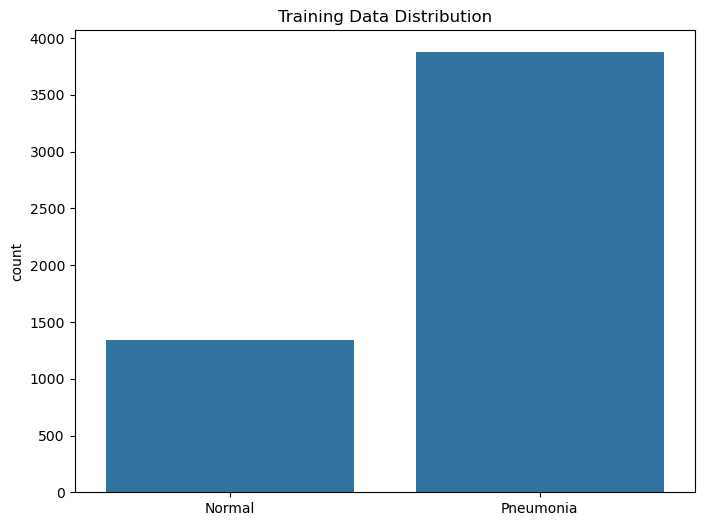


Data shapes:
X_train: (5216, 256, 256, 1), y_train: (5216,)
X_val: (16, 256, 256, 1), y_val: (16,)
X_test: (624, 256, 256, 1), y_test: (624,)

Building CNN model...


C:\Users\varun raj\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,165,569 (65.48 MB)

 Trainable params: 17,165,569 (65.48 MB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 782ms/step - accuracy: 0.7818 - loss: 0.4613 - val_accuracy: 0.5625 - val_loss: 0.6388
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 756ms/step - accuracy: 0.9091 - loss: 0.2482 - val_accuracy: 0.8125 - val_loss: 0.5433
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 765ms/step - accuracy: 0.9204 - loss: 0.2008 - val_accuracy: 0.7500 - val_loss: 0.5406
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 783ms/step - accuracy: 0.9425 - loss: 0.1589 - val_accuracy: 0.6250 - val_loss: 0.5772
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 782ms/step - accuracy: 0.9392 - loss: 0.1558 - val_accuracy: 0.7500 - val_loss: 0.4970
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 781ms/step - accuracy: 0.9454 - loss: 0.1404 - val_accuracy: 0.7500 - val_loss: 0.4874
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 791ms/step - accuracy: 0.9484 - loss: 0.1318 - val_accuracy: 0.8125 - val_loss: 0.4490
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 773ms/step -

Test loss: 0.4246
Test accuracy: 0.8269

Model saved as 'cnn_model.h5'

Generating training visualizations...


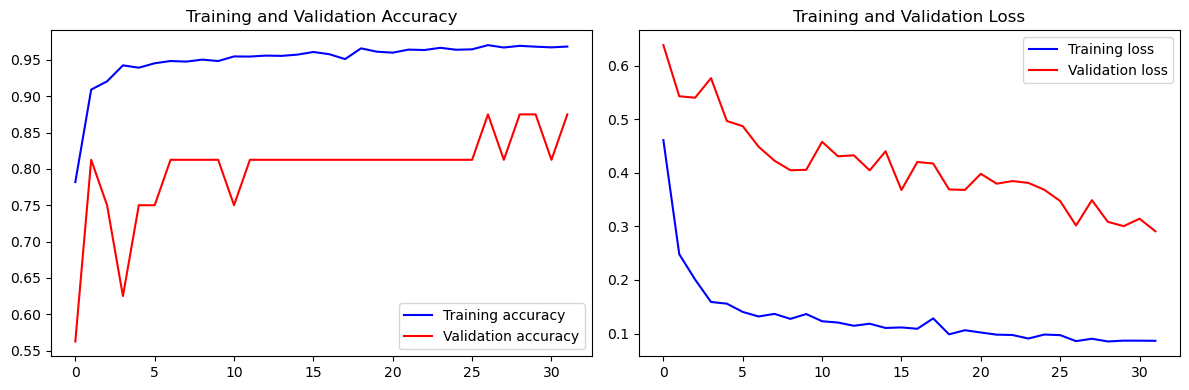


Making predictions on test data...
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step
Correct predictions: 516
Incorrect predictions: 108


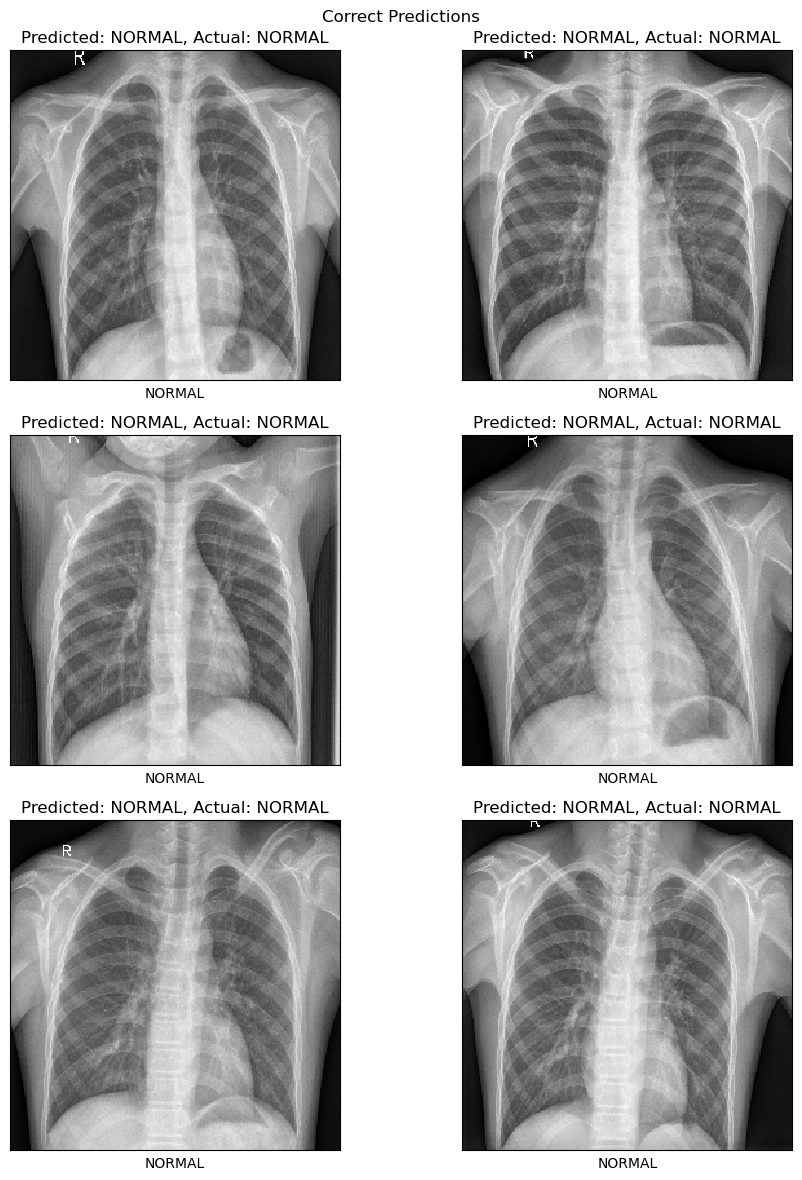

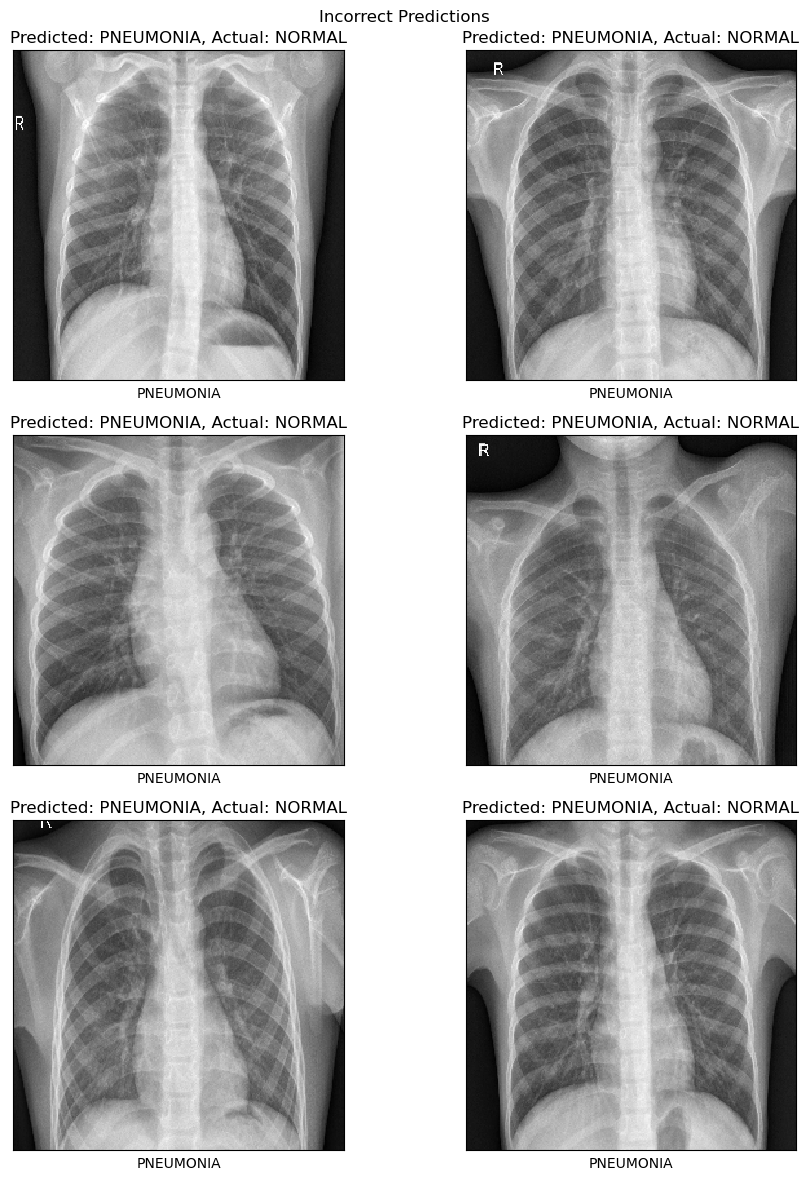


=== Prediction on External Images ===
To predict on a new image, use:
prediction = model.predict([prepare('path/to/image.jpg')])
result = labels[int(prediction[0] > 0.5)]
print(f'Prediction: {result}')


'\n# Load saved model\nmodel = tf.keras.models.load_model("ccnn_model.keras")\n\n# Predict on external images\nprediction = model.predict([prepare("path/to/pneumonia_image.jpg")])\nprint(f"Prediction: {labels[int(prediction[0] > 0.5)]}")\n\nprediction = model.predict([prepare("path/to/normal_image.jpg")])\nprint(f"Prediction: {labels[int(prediction[0] > 0.5)]}")\n'

In [3]:
"""
Pneumonia Detection from Chest X-Ray Images using CNN
This program trains a convolutional neural network to classify chest X-rays 
as either NORMAL or PNEUMONIA.
"""

# Install required package (run in terminal):
# pip install opencv-python

import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Conv2D, Activation, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential

# Configuration
IMG_SIZE = 256
labels = ["NORMAL", "PNEUMONIA"]

# Directory paths
train_folder = "chest_xray/train"
test_folder = "chest_xray/test"
val_folder = "chest_xray/val"

def get_data(data_dir):
    """
    Load and preprocess image data from directory
    
    Args:
        data_dir: Path to data directory containing NORMAL and PNEUMONIA folders
    
    Returns:
        numpy array containing [image_array, class_label] pairs
    """
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, class_num])
            except Exception as e:
                print(f"Error loading {img}: {e}")
    return np.array(data, dtype=object)

# Load datasets
print("Loading training data...")
train = get_data(train_folder)
print("Loading test data...")
test = get_data(test_folder)
print("Loading validation data...")
val = get_data(val_folder)

# Visualize class distribution
print("\nVisualizing class distribution...")
l = ["Normal" if i[1] == 0 else "Pneumonia" for i in train]
plt.figure(figsize=(8, 6))
sns.countplot(x=l)
plt.title("Training Data Distribution")
plt.show()

# Prepare training data
X_train = []
y_train = []
for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

# Prepare test data
X_test = []
y_test = []
for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

# Prepare validation data
X_val = []
y_val = []
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

# Normalize pixel values to [0, 1]
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

# Reshape for CNN input (samples, height, width, channels)
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

print(f"\nData shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Build CNN Model
print("\nBuilding CNN model...")
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]),
    Activation("relu"),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), padding="same"),
    Activation("relu"),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    
    # Third convolutional block
    Conv2D(128, (3, 3), padding="same"),
    Activation("relu"),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    
    # Fourth convolutional block
    Conv2D(256, (3, 3), padding="same"),
    Activation("relu"),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    
    # Fully connected layers
    Flatten(),
    Dense(256, activation="relu"),
    Dense(1),
    Activation("sigmoid")
])

# Compile model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()

# Train model
print("\nTraining model...")
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    validation_data=(X_val, y_val), 
    shuffle=True, 
    callbacks=[callback]
)

# Evaluate model
print("\nEvaluating model on test data...")
scores = model.evaluate(X_test, y_test)
print(f"Test loss: {scores[0]:.4f}")
print(f"Test accuracy: {scores[1]:.4f}")

# Save model
model.save("cnn_model.h5")
print("\nModel saved as 'cnn_model.h5'")

# Visualize training history
print("\nGenerating training visualizations...")
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions
print("\nMaking predictions on test data...")
predictions = (model.predict(X_test) > 0.5).astype(int).reshape(-1)

# Find correct and incorrect predictions
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

print(f"Correct predictions: {len(correct)}")
print(f"Incorrect predictions: {len(incorrect)}")

# Visualize correct predictions
plt.figure(figsize=(10, 12))
for j, i in enumerate(correct[:6]):
    plt.subplot(3, 2, j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i].reshape(256, 256), cmap="gray", interpolation='none')
    plt.title(f"Predicted: {labels[predictions[i]]}, Actual: {labels[y_test[i]]}")
    plt.xlabel(labels[predictions[i]])
plt.suptitle("Correct Predictions")
plt.tight_layout()
plt.show()

# Visualize incorrect predictions
if len(incorrect) > 0:
    plt.figure(figsize=(10, 12))
    for j, i in enumerate(incorrect[:6]):
        plt.subplot(3, 2, j+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(X_test[i].reshape(256, 256), cmap="gray", interpolation='none')
        plt.title(f"Predicted: {labels[predictions[i]]}, Actual: {labels[y_test[i]]}")
        plt.xlabel(labels[predictions[i]])
    plt.suptitle("Incorrect Predictions")
    plt.tight_layout()
    plt.show()

# Function to prepare external images for prediction
def prepare(filepath):
    """
    Prepare an external image for prediction
    
    Args:
        filepath: Path to image file
    
    Returns:
        Preprocessed image array ready for model prediction
    """
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    normalized = new_array / 255.0
    return normalized.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Example: Load model and predict on new images
print("\n=== Prediction on External Images ===")
print("To predict on a new image, use:")
print("prediction = model.predict([prepare('path/to/image.jpg')])")
print("result = labels[int(prediction[0] > 0.5)]")
print("print(f'Prediction: {result}')")

# Uncomment below to test on external images:
"""
# Load saved model
model = tf.keras.models.load_model("ccnn_model.keras")

# Predict on external images
prediction = model.predict([prepare("path/to/pneumonia_image.jpg")])
print(f"Prediction: {labels[int(prediction[0] > 0.5)]}")

prediction = model.predict([prepare("path/to/normal_image.jpg")])
print(f"Prediction: {labels[int(prediction[0] > 0.5)]}")
"""